# GRU Model Training

In this notebook, we will train a GRU-based RNN model for sentiment analysis.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

# Load the processed data
processed_path = "../../data/processed/amazon_reviews_processed.csv"
df = pd.read_csv(processed_path)

# Convert polarity to binary labels
df['label'] = df['polarity'].map({1: 0, 2: 1})

# Define features and labels
X = df['cleaned_review']
y = df['label']

# Split the data into training, validation and test sets
# Using 60/20/20 split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

print("Training set size: ", len(X_train))
print("Validation set size: ", len(X_val))
print("Test set size: ", len(X_test))

Training set size:  119988
Validation set size:  39997
Test set size:  39997


In [3]:
# Configuration Parameters
import os

# Tokenization & Padding
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 70
OOV_TOKEN = "<OOV>"

# Model Parameters
EMBEDDING_DIM = 64
GRU_UNITS = 64
DROPOUT_RATE = 0.3

# Training Parameters
EPOCHS = 10
BATCH_SIZE = 64
LEARNING_RATE = 0.001

# Define paths for saving model artifacts
MODEL_ARTIFACTS_DIR = "../../models/rnn-gru"
os.makedirs(MODEL_ARTIFACTS_DIR, exist_ok=True)

MODEL_SAVE_PATH = os.path.join(MODEL_ARTIFACTS_DIR, "best_model.keras")
TOKENIZER_SAVE_PATH = os.path.join(MODEL_ARTIFACTS_DIR, "tokenizer.pickle")
HISTORY_PLOT_SAVE_PATH = os.path.join(MODEL_ARTIFACTS_DIR, "training_history.png")

print("Configuration parameters set.")
print(f"Model artifacts will be saved in: '{MODEL_ARTIFACTS_DIR}'")

Configuration parameters set.
Model artifacts will be saved in: '../../models/rnn-gru'


In [4]:
# Tokenization and Padding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

print("Starting tokenization and padding...")

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

print(f"\nPadded sequence shapes:")
print(f"Training: {X_train_pad.shape}")
print(f"Validation: {X_val_pad.shape}")
print(f"Test: {X_test_pad.shape}")

# Save tokenizer
with open(TOKENIZER_SAVE_PATH, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"\nTokenizer saved to: {TOKENIZER_SAVE_PATH}")

Starting tokenization and padding...

Padded sequence shapes:
Training: (119988, 70)
Validation: (39997, 70)
Test: (39997, 70)

Tokenizer saved to: ../../models/rnn-gru\tokenizer.pickle


In [5]:
# Build GRU Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, SpatialDropout1D, Bidirectional

model = Sequential([
    Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBEDDING_DIM,
        input_length=MAX_SEQUENCE_LENGTH,
        mask_zero=True
    ),
    SpatialDropout1D(DROPOUT_RATE),
    Bidirectional(
        GRU(
            units=GRU_UNITS,
            dropout=DROPOUT_RATE,
            recurrent_dropout=0.0,
            return_sequences=False
        )
    ),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

c:\Users\adamy\Documents\DAT255-Project\env\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Define callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    filepath=MODEL_SAVE_PATH,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

callbacks_list = [early_stopping, model_checkpoint]

In [ ]:
# Train model
history = model.fit(
    X_train_pad, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_pad, y_val),
    callbacks=callbacks_list,
    verbose=1
)

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig(HISTORY_PLOT_SAVE_PATH)
plt.show()

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8247 - loss: 0.3699
Epoch 1: val_loss improved from inf to 0.27147, saving model to ../../models/rnn-gru\best_model.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 100s 51ms/step - accuracy: 0.8247 - loss: 0.3699 - val_accuracy: 0.8859 - val_loss: 0.2715
Epoch 2/10
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9032 - loss: 0.2397
Epoch 2: val_loss improved from 0.27147 to 0.26946, saving model to ../../models/rnn-gru\best_model.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 99s 53ms/step - accuracy: 0.9032 - loss: 0.2397 - val_accuracy: 0.8897 - val_loss: 0.2695
Epoch 3/10
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9146 - loss: 0.2165
Epoch 3: val_loss did not improve from 0.26946
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 103s 55ms/step - accuracy: 0.9146 - loss: 0.2165 - val_accuracy: 0.8907 - val_loss: 0.2781
Epoch 4/10
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9278 - loss: 0.1880
Epoch 4: val_loss improv

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     19765
           1       0.89      0.90      0.89     20232

    accuracy                           0.89     39997
   macro avg       0.89      0.89      0.89     39997
weighted avg       0.89      0.89      0.89     39997



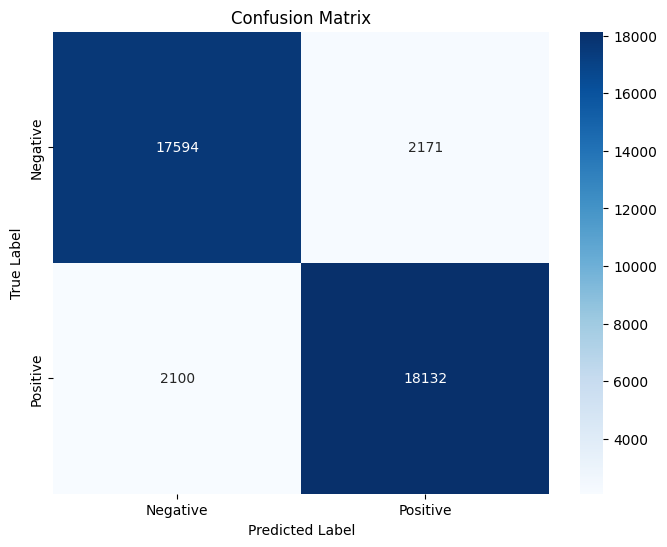

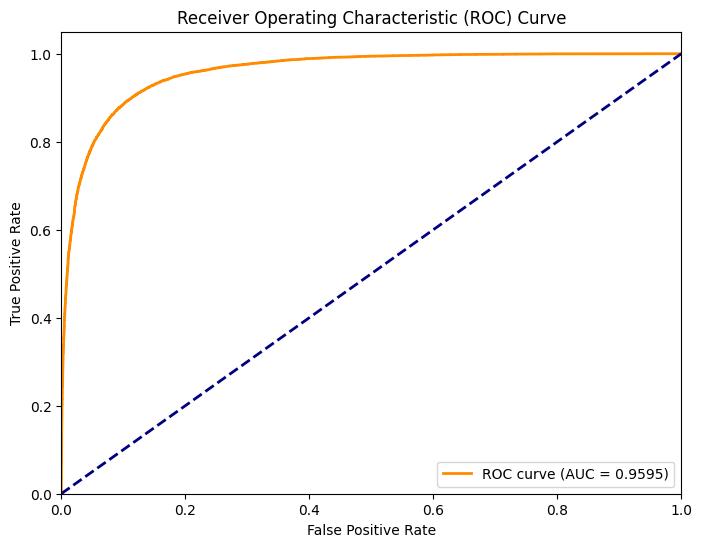

In [8]:
# Load best model and evaluate
best_model = tf.keras.models.load_model(MODEL_SAVE_PATH)

# Generate predictions
y_pred_probs = best_model.predict(X_test_pad, verbose=1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Print classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()